In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import requests
import os

In [3]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Data Modelling 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "9g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

24/09/29 10:53:15 WARN Utils: Your hostname, LAPTOP-406UJ3L3 resolves to a loopback address: 127.0.1.1; using 172.21.136.1 instead (on interface eth0)
24/09/29 10:53:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/29 10:53:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/29 10:53:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read dataset

In [3]:
# Information on merchants
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")

# Information on merchant's fraud probability
merchant_fraud_prob = pd.read_csv("../data/tables/part_1/merchant_fraud_probability.csv")

### Preprocessing `goods` feature

In [4]:
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import monotonically_increasing_id

In [5]:
goods = merchant.select("goods")

In [6]:
clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))

tokenizer = Tokenizer(inputCol="str_goods", outputCol="tokens")
clean_goods = tokenizer.transform(clean_goods)

remover = StopWordsRemover(inputCol="tokens", outputCol="clean_goods")
clean_goods = remover.transform(clean_goods)
clean_goods = clean_goods.select('clean_goods')

In [7]:
count_vectorizer = CountVectorizer(inputCol="clean_goods", outputCol="features")

model = count_vectorizer.fit(clean_goods)
result = model.transform(clean_goods)

In [8]:
result.limit(4)

clean_goods,features
"[watch, clock, je...","(94,[0,12,13,14,5..."
"[motor, vehicle, ...","(94,[5,71,72,76,7..."
"[cable, satellite...","(94,[4,44,45,46,4..."
"[opticians, optic...","(94,[9,73,74,75],..."


In [9]:
pca = PCA(k=12, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(result)
pca_result = model.transform(result)

24/09/29 08:09:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [10]:
model.transform(result).collect()[0].pca_features

DenseVector([0.7685, -0.6656, 0.3307, -0.7595, -0.0918, -0.2737, 0.9877, 1.0146, 0.314, 0.568, -0.028, -0.0165])

In [11]:
model.explainedVariance.sum()

np.float64(0.7348035599530366)

In [12]:
pca_result = pca_result.withColumn("id", monotonically_increasing_id())
merchant = merchant.withColumn("id", monotonically_increasing_id())

In [13]:
merchant = merchant.join(pca_result.select('pca_features', 'id'), on='id', how='inner')
merchant = merchant.drop("id")

In [14]:
from pyspark.sql.functions import when

In [15]:
# Define the ordered categories
ordered_categories = ['a', 'b', 'c', 'd', 'e']

# Map the categories to their corresponding ordinal codes
merchant = merchant.withColumn(
    "ordinal_revenue_level",
    when(F.col("revenue_level") == "a", 0)
    .when(F.col("revenue_level") == "b", 1)
    .when(F.col("revenue_level") == "c", 2)
    .when(F.col("revenue_level") == "d", 3)
    .when(F.col("revenue_level") == "e", 4)
)

merchant = merchant.drop("revenue_level")

### Join transaction dataset

In [16]:
temp = spark.read.parquet('../data/curated/all_details/')
temp.limit(5)

order_id,user_id,merchant_abn,order_datetime,dollar_value,postcode,merchant_fraud,consumer_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,sa2_code,sa2_name
6a84c3cf-612a-457...,2,15549624934,2021-08-20,130.3505283105634,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
a1ff2d13-c888-469...,2,79417999332,2021-08-21,132.70580024651548,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
ccdb41fa-a5ab-472...,2,64203420245,2021-08-21,3.0641677344299336,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
4fbc20d0-1e21-4b5...,2,66842618444,2021-08-19,189.45042103113855,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls
c7acb95f-2cf8-4ae...,2,30122382323,2021-08-22,37.72939540011015,2782,0.0,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,124011455,Wentworth Falls


In [17]:
full_dataset = temp.join(merchant, on='merchant_abn', how='left')
full_dataset.count()

14195505

In [18]:
# Select useful columns
merchant_is_fraud_model = full_dataset.select(["order_id", "merchant_abn", "user_id", "order_datetime", "dollar_value", "postcode", "merchant_fraud", "weekly_personal_disposable",
                     "median_total_household_income", "median_total_family_income", "avg_household_size", "median_age", "is_po_box", "ordinal_revenue_level" ,"take_rate", "pca_features"])

We check the number of Null values in merchant fraud probability.

In [19]:
merchant_is_fraud_model.filter(F.col('merchant_fraud') > 0).count()

4059

In [20]:
merchant_is_fraud_model.limit(5)

order_id,merchant_abn,user_id,order_datetime,dollar_value,postcode,merchant_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,ordinal_revenue_level,take_rate,pca_features
4fbc20d0-1e21-4b5...,66842618444,2,2021-08-19,189.45042103113855,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,0,6.93,[0.57387151449309...
6a84c3cf-612a-457...,15549624934,2,2021-08-20,130.3505283105634,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,2,2.76,[-0.1654801171818...
a1ff2d13-c888-469...,79417999332,2,2021-08-21,132.70580024651548,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,1,4.95,[0.68120365907528...
ccdb41fa-a5ab-472...,64203420245,2,2021-08-21,3.0641677344299336,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,2,2.86,[0.60148507156068...
c7acb95f-2cf8-4ae...,30122382323,2,2021-08-22,37.72939540011015,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,1,3.36,[0.76854023445623...


## Feature selection

We want to check the correlation between each attribute using a subsample dataset. The subsample dataset contains 30% of the 2022 data and 70% of the 2021 data as we will train model on the data in 2021 and test it on the data in 2022.

In [21]:
from pyspark.sql.functions import year
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
sample_merchant_fraud_df = merchant_is_fraud_model.sample(0.01, seed=42).toPandas()

<Axes: >

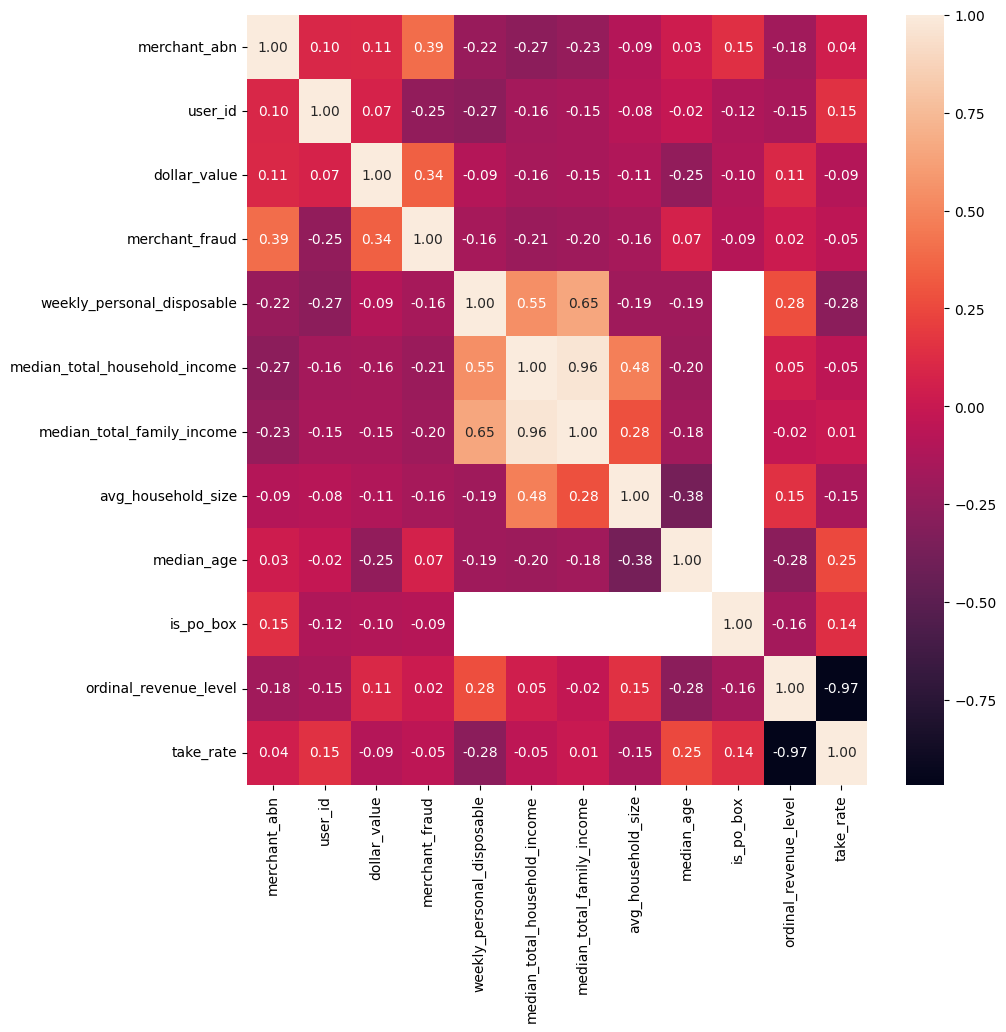

In [23]:
num_cols = [col for col in sample_merchant_fraud_df.columns if sample_merchant_fraud_df[col].dtype != 'object']

plt.figure(figsize=(10, 10))
sns.heatmap(sample_merchant_fraud_df.loc[sample_merchant_fraud_df['merchant_fraud'] > 0][num_cols].corr(), annot=True, fmt='.2f')

Because pyspark ml can't handle Null values, we drop external attributes that contain Null values.

In [24]:
selected_features = ["order_id", "merchant_abn", "dollar_value", "merchant_fraud", "ordinal_revenue_level" ,"take_rate", "order_datetime", "pca_features"]
impute_merchant_fraud_sdf = merchant_is_fraud_model.select(selected_features)
impute_merchant_fraud_sdf.limit(5)

order_id,merchant_abn,dollar_value,merchant_fraud,ordinal_revenue_level,take_rate,order_datetime,pca_features
4fbc20d0-1e21-4b5...,66842618444,189.45042103113855,0.0,0,6.93,2021-08-19,[0.57387151449309...
6a84c3cf-612a-457...,15549624934,130.3505283105634,0.0,2,2.76,2021-08-20,[-0.1654801171818...
a1ff2d13-c888-469...,79417999332,132.70580024651548,0.0,1,4.95,2021-08-21,[0.68120365907528...
ccdb41fa-a5ab-472...,64203420245,3.0641677344299336,0.0,2,2.86,2021-08-21,[0.60148507156068...
c7acb95f-2cf8-4ae...,30122382323,37.72939540011015,0.0,1,3.36,2021-08-22,[0.76854023445623...


In [25]:
impute_merchant_fraud_sdf.count()

14195505

In [26]:
impute_merchant_fraud_sdf.filter(F.col("take_rate").isNotNull()).count()

13614675

As we expected, there are some merchants not existing in transaction dataset, we will remove those instances.

In [27]:
impute_merchant_fraud_sdf = impute_merchant_fraud_sdf.filter(F.col("take_rate").isNotNull())

Let's check the number of instances with non-missing fraud probability.

In [28]:
impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') > 0).count()

4003

We would like to use these instances to build a imputation model for the remaining null values.

In [29]:
model_df = impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') > 0)

In [30]:
final_df = model_df.dropna('any')
final_df.count()

4003

In [31]:
final_df.limit(5)

order_id,merchant_abn,dollar_value,merchant_fraud,ordinal_revenue_level,take_rate,order_datetime,pca_features
22dc7041-b0ad-481...,90568944804,337.1027629208633,33.172494688960434,1,4.1,2021-11-29,[0.60148507156068...
9c80632c-a583-443...,90568944804,1426.6980041595448,28.583030842180733,1,4.1,2021-11-26,[0.60148507156068...
8b77c209-aa0b-432...,90568944804,947.4542779688253,28.583030842180733,1,4.1,2021-11-26,[0.60148507156068...
ce843f16-f672-482...,90568944804,2754.306049659226,33.172494688960434,1,4.1,2021-11-29,[0.60148507156068...
1351655e-d6e3-48f...,90568944804,785.5357027024718,30.41342923227757,1,4.1,2021-11-28,[0.60148507156068...


In [32]:
# Save data to file
final_df.write.mode('overwrite').parquet('../data/curated/modelling/')

In [33]:
model_sdf = spark.read.parquet('../data/curated/modelling')

## Train Random Forest regression

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [35]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = model_sdf.randomSplit([0.8, 0.2], seed=42)

In [36]:
print(trainingData.count())
print(testData.count())

3260
743


### Baseline Model

The model only predicts the mean value for all test instances.

In [37]:
mean_value = testData.agg(F.mean("merchant_fraud")).collect()[0][0]
mean_predictions_df = testData.select("merchant_fraud").withColumn("prediction", F.lit(mean_value))

mse_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(mean_predictions_df)
mae = mae_evaluator.evaluate(mean_predictions_df)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Square Error: 28.812977419553015
Mean Absolute Error: 2.0507967686080995


### Random Forest

We aim to create a simple model, therefore, the model hyperparameters were chosen arbitrarily.

In [38]:
features = 'features'
input_cols = trainingData.drop('merchant_fraud').drop('order_id').drop('order_datetime').drop('merchant_abn').columns

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

final_model_sdf = assembler.transform(trainingData)

# Display the features and targets for our model
final_model_sdf.select('features').head(5), final_model_sdf.select('merchant_fraud').head(5)

([Row(features=DenseVector([38.746, 0.0, 6.64, -0.1655, 0.0143, -0.322, 0.2051, -0.3855, -0.0532, 0.3222, -0.5522, 0.2012, 0.2745, 0.0307, 0.0785])),
  Row(features=DenseVector([487.0467, 1.0, 3.49, -0.2525, 0.2775, 0.6791, 0.7797, -0.0343, -0.4915, 0.256, 0.4401, -1.0545, -0.4485, 0.1911, 1.167])),
  Row(features=DenseVector([260.1799, 0.0, 6.64, -0.1655, 0.0143, -0.322, 0.2051, -0.3855, -0.0532, 0.3222, -0.5522, 0.2012, 0.2745, 0.0307, 0.0785])),
  Row(features=DenseVector([128.5033, 2.0, 2.73, -0.6054, 0.0271, -0.412, -0.1978, 1.4762, 0.1491, -0.0966, 0.1782, 0.4036, 0.0766, 1.5563, 0.002])),
  Row(features=DenseVector([168.223, 1.0, 4.8, 0.6125, 2.529, 0.9421, -0.0103, 0.1644, -0.5881, 0.2788, 0.062, 0.6116, -0.1987, -0.0344, -0.3314]))],
 [Row(merchant_fraud=28.36052168812278),
  Row(merchant_fraud=30.024291830924508),
  Row(merchant_fraud=28.36052168812278),
  Row(merchant_fraud=29.520113582407653),
  Row(merchant_fraud=29.13305311007307)])

In [39]:
model = RandomForestRegressor(
    featuresCol='features', 
    labelCol='merchant_fraud',
    numTrees=5, 
    maxDepth=5,
    seed=42
).fit(final_model_sdf)

- Make predictions.

In [40]:
# preprocess for predictions
predict_test = testData.select(*input_cols)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test.dropna('any')).select(features)

In [41]:
predictions = model.transform(predict_sdf)

- Evaluate the predictions.

In [42]:
predictions_id = predictions.withColumn("id", monotonically_increasing_id())
testData_id = testData.withColumn("id", monotonically_increasing_id())
result_sdf = predictions_id.join(testData_id.select('merchant_fraud', 'id'), on='id', how='inner')
result_sdf = result_sdf.drop("id")

In [43]:
mse_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(result_sdf)
mae = mae_evaluator.evaluate(result_sdf)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Square Error: 13.748140859208299
Mean Absolute Error: 1.1435894460496325


In [44]:
result_sdf.limit(10)

features,prediction,merchant_fraud
[265.368055765011...,29.601188994533352,29.555244690425017
[4774.14498387908...,31.629440282202676,31.537398474248477
[224.705278499361...,28.95650134866877,28.1008562280967
[58.9826434040859...,28.79422838800745,28.504479048104585
[23497.2634972758...,34.80496563044315,30.761664332047506
[253.680913792603...,29.593382029675617,29.539733207182703
[118.317853127597...,28.81793745102787,28.36052168812278
[3073.72862745050...,34.80496563044315,30.761664332047506
[89.1832750752898...,28.81793745102787,28.33737019623005
[455.548431600914...,29.601188994533352,27.58235777292768


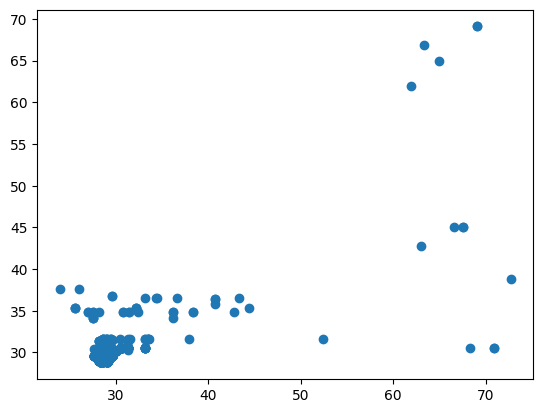

In [45]:
result_pd = result_sdf.select("prediction", "merchant_fraud").toPandas()
plt.scatter(result_pd.merchant_fraud, result_pd.prediction)

### Imputation for merchant fraud probability

In [50]:
imputation_data = impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') == 0).drop('merchant_fraud')

In [51]:
# preprocess for predictions
predict_imputation = imputation_data.select(*input_cols)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

imputation_sdf = assembler.transform(predict_imputation).select(features)

In [52]:
imputed_sdf = model.transform(imputation_sdf)

In [53]:
imputed_sdf.describe()

summary,prediction
count,13610672
mean,35.326390525722054
stddev,10.384028596608687
min,28.79422838800745
max,69.09531723361195


We merge imputed merchant fraud probability to the main dataset.

In [54]:
imputed_sdf_id = imputed_sdf.select("prediction").withColumnRenamed("prediction", "merchant_fraud")
imputation_data = imputation_data.select("order_id")

Now, we save imputed merchant fraud probability with the order_id.

In [57]:
from pyspark.sql.window import Window

In [58]:
imputed_sdf_id = imputed_sdf_id.withColumn("idx", F.monotonically_increasing_id())
windowSpec = Window.orderBy("idx")
imputed_sdf_id = imputed_sdf_id.withColumn("idx", F.row_number().over(windowSpec))

imputation_data = imputation_data.withColumn("idx", F.monotonically_increasing_id())
windowSpec = Window.orderBy("idx")
imputation_data = imputation_data.withColumn("idx", F.row_number().over(windowSpec))

In [59]:
imputation_data.count()

13610672

In [60]:
imputed_sdf_detail = imputation_data.join(imputed_sdf_id, on='idx', how='inner')
imputed_sdf_detail = imputed_sdf_detail.drop("idx")

In [61]:
# data with given merchant fraud probability
non_missing_merchant_fraud = model_sdf.select(["order_id", "merchant_fraud"])

# Combine two dataset
full_merchant_fraud = imputed_sdf_detail.union(non_missing_merchant_fraud)

In [ ]:
# Save data to file
full_merchant_fraud.write.mode('overwrite').parquet('../data/curated/predicted_merchant_fraud/')

In [4]:
test = spark.read.parquet('../data/curated/predicted_merchant_fraud/')

24/09/29 10:53:20 ERROR Executor: Exception in task 0.0 in stage 0.0 (TID 0)
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.util.ThreadUtils$.parmap(ThreadUtils.scala:387)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.readParquetFootersInParallel(ParquetFileFormat.scala:443)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1(ParquetFileFormat.scala:493)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1$adapted(ParquetFileFormat.scala:485)
	at org.apache.spark.sql.execution.datasources.SchemaMergeUtils$.$anonfun$mergeSchemasInParallel$2(SchemaMergeUtils.scala:80)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.

Py4JJavaError: An error occurred while calling o35.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (172.21.136.1 executor driver): org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.util.ThreadUtils$.parmap(ThreadUtils.scala:387)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.readParquetFootersInParallel(ParquetFileFormat.scala:443)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1(ParquetFileFormat.scala:493)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1$adapted(ParquetFileFormat.scala:485)
	at org.apache.spark.sql.execution.datasources.SchemaMergeUtils$.$anonfun$mergeSchemasInParallel$2(SchemaMergeUtils.scala:80)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: [CANNOT_READ_FILE_FOOTER] Could not read footer for file: file:/mnt/d/Lam/Unimelb/Third_year/AppliedDS/project-2-group-buy-now-pay-later-industry-project-33/data/curated/predicted_merchant_fraud/part-00000-91a36d86-1b99-4801-ae88-c000804e4e9b-c000.snappy.parquet.crc. Please ensure that the file is in either ORC or Parquet format. If not, please convert it to a valid format. If the file is in the valid format, please check if it is corrupt. If it is, you can choose to either ignore it or fix the corruption.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFooterForFileError(QueryExecutionErrors.scala:1056)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$readParquetFootersInParallel$1(ParquetFileFormat.scala:456)
	at org.apache.spark.util.ThreadUtils$.$anonfun$parmap$2(ThreadUtils.scala:384)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.util.concurrent.ForkJoinTask$RunnableExecuteAction.exec(ForkJoinTask.java:1402)
	at java.util.concurrent.ForkJoinTask.doExec(ForkJoinTask.java:289)
	at java.util.concurrent.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:1056)
	at java.util.concurrent.ForkJoinPool.runWorker(ForkJoinPool.java:1692)
	at java.util.concurrent.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:175)
Caused by: java.lang.RuntimeException: file:/mnt/d/Lam/Unimelb/Third_year/AppliedDS/project-2-group-buy-now-pay-later-industry-project-33/data/curated/predicted_merchant_fraud/part-00000-91a36d86-1b99-4801-ae88-c000804e4e9b-c000.snappy.parquet.crc is not a Parquet file. Expected magic number at tail, but found [-125, -33, -127, -56]
	at org.apache.parquet.hadoop.ParquetFileReader.readFooter(ParquetFileReader.java:565)
	at org.apache.parquet.hadoop.ParquetFileReader.<init>(ParquetFileReader.java:799)
	at org.apache.parquet.hadoop.ParquetFileReader.open(ParquetFileReader.java:666)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFooterReader.readFooter(ParquetFooterReader.java:85)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFooterReader.readFooter(ParquetFooterReader.java:76)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$readParquetFootersInParallel$1(ParquetFileFormat.scala:450)
	... 13 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.datasources.SchemaMergeUtils$.mergeSchemasInParallel(SchemaMergeUtils.scala:74)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.mergeSchemasInParallel(ParquetFileFormat.scala:497)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetUtils$.inferSchema(ParquetUtils.scala:132)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.inferSchema(ParquetFileFormat.scala:79)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:563)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.util.ThreadUtils$.parmap(ThreadUtils.scala:387)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.readParquetFootersInParallel(ParquetFileFormat.scala:443)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1(ParquetFileFormat.scala:493)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$mergeSchemasInParallel$1$adapted(ParquetFileFormat.scala:485)
	at org.apache.spark.sql.execution.datasources.SchemaMergeUtils$.$anonfun$mergeSchemasInParallel$2(SchemaMergeUtils.scala:80)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: [CANNOT_READ_FILE_FOOTER] Could not read footer for file: file:/mnt/d/Lam/Unimelb/Third_year/AppliedDS/project-2-group-buy-now-pay-later-industry-project-33/data/curated/predicted_merchant_fraud/part-00000-91a36d86-1b99-4801-ae88-c000804e4e9b-c000.snappy.parquet.crc. Please ensure that the file is in either ORC or Parquet format. If not, please convert it to a valid format. If the file is in the valid format, please check if it is corrupt. If it is, you can choose to either ignore it or fix the corruption.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFooterForFileError(QueryExecutionErrors.scala:1056)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$readParquetFootersInParallel$1(ParquetFileFormat.scala:456)
	at org.apache.spark.util.ThreadUtils$.$anonfun$parmap$2(ThreadUtils.scala:384)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.util.concurrent.ForkJoinTask$RunnableExecuteAction.exec(ForkJoinTask.java:1402)
	at java.util.concurrent.ForkJoinTask.doExec(ForkJoinTask.java:289)
	at java.util.concurrent.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:1056)
	at java.util.concurrent.ForkJoinPool.runWorker(ForkJoinPool.java:1692)
	at java.util.concurrent.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:175)
Caused by: java.lang.RuntimeException: file:/mnt/d/Lam/Unimelb/Third_year/AppliedDS/project-2-group-buy-now-pay-later-industry-project-33/data/curated/predicted_merchant_fraud/part-00000-91a36d86-1b99-4801-ae88-c000804e4e9b-c000.snappy.parquet.crc is not a Parquet file. Expected magic number at tail, but found [-125, -33, -127, -56]
	at org.apache.parquet.hadoop.ParquetFileReader.readFooter(ParquetFileReader.java:565)
	at org.apache.parquet.hadoop.ParquetFileReader.<init>(ParquetFileReader.java:799)
	at org.apache.parquet.hadoop.ParquetFileReader.open(ParquetFileReader.java:666)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFooterReader.readFooter(ParquetFooterReader.java:85)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFooterReader.readFooter(ParquetFooterReader.java:76)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.$anonfun$readParquetFootersInParallel$1(ParquetFileFormat.scala:450)
	... 13 more


In [49]:
test.count()

9494690